In [ ]:
pip install opencv-python

Note: you may need to restart the kernel to use updated packages.


In [2]:
pip install matplotlib

Note: you may need to restart the kernel to use updated packages.


In [3]:
!pip install pycolmap open3d

Librerias necesarias

In [4]:
import cv2
import os
import matplotlib.pyplot as plt
import numpy as np

# Preprocesamiento de Imágenes

Cargar imágenes

In [5]:
image_folder = '/Users/isabela/Desktop/IsabelaRuiz_NataliaCabrera/imagenes'
images = [cv2.imread(os.path.join(image_folder, fname)) for fname in os.listdir(image_folder)]


In [6]:
image_folder = '/Users/isabela/Desktop/IsabelaRuiz_NataliaCabrera/imagenes'
images = []

for fname in os.listdir(image_folder):
    # Ignorar archivos ocultos y verificar extensión
    if not fname.startswith('.') and fname.lower().endswith(('.png', '.jpg', '.jpeg')):
        img_path = os.path.join(image_folder, fname)
        img = cv2.imread(img_path)
        if img is None:
            print(f"Error: No se pudo cargar la imagen {fname}")
        else:
            images.append(img)

# Verificar cuántas imágenes se cargaron correctamente
print(f"Se cargaron {len(images)} imágenes correctamente.")

Se cargaron 24 imágenes correctamente.


Convertir a escala de grises

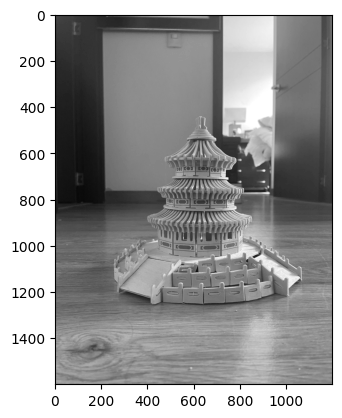

In [7]:
gray_images = [cv2.cvtColor(img, cv2.COLOR_BGR2GRAY) for img in images]
plt.imshow(gray_images[0], cmap='gray')
plt.show()

# Detección de Características y Emparejamiento

Detección de Características

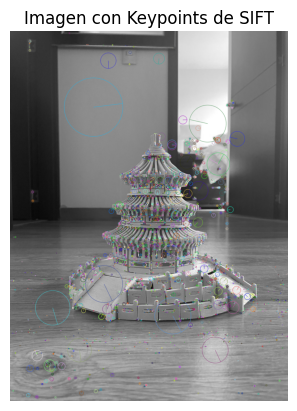

In [ ]:
import cv2
import matplotlib.pyplot as plt

sift = cv2.SIFT_create()

img = gray_images[0]

# Detectar keypoints y calcular descriptores
kp, des = sift.detectAndCompute(img, None)

# Dibujar los keypoints sobre la imagen
img_with_keypoints = cv2.drawKeypoints(img, kp, None, flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)

# Mostrar la imagen con los keypoints
plt.imshow(img_with_keypoints)
plt.title("Imagen con Keypoints de SIFT")
plt.axis("off") 
plt.show()


Emparejamiento de Características

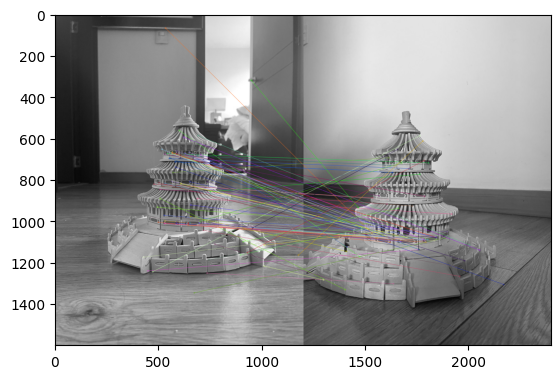

In [12]:
bf = cv2.BFMatcher()
matches = bf.knnMatch(descriptors[0], descriptors[1], k=2)

# Filtrar emparejamientos usando el ratio de Lowe
good_matches = []
for m, n in matches:
    if m.distance < 0.75 * n.distance:
        good_matches.append(m)

# Dibujar emparejamientos
img_matches = cv2.drawMatches(gray_images[0], keypoints[0], gray_images[1], keypoints[1], good_matches, None, flags=2)
plt.imshow(img_matches)
plt.show()

El ratio de Lowe es un número específico (0.75) que se usa para decidir si una coincidencia entre características es buena o no.

# Estimación de la Matriz Fundamental y la Matriz Esencial

Calcular la matriz fundamental usando RANSAC

In [13]:
import numpy as np
import cv2

# Suponiendo que ya tienes los puntos clave (keypoints) y las buenas correspondencias (good_matches) calculadas

pts1 = np.float32([keypoints[0][m.queryIdx].pt for m in good_matches])
pts2 = np.float32([keypoints[1][m.trainIdx].pt for m in good_matches])

# Calculando la matriz fundamental usando RANSAC
F, mask = cv2.findFundamentalMat(pts1, pts2, cv2.FM_RANSAC)

# Imprimir la matriz fundamental
print("Matriz Fundamental F:")
print(F)


Matriz Fundamental F:
[[ 5.79199190e-07 -9.07969984e-06  8.79654356e-03]
 [ 2.71076717e-06  3.29022585e-06 -5.21074417e-03]
 [-3.26924615e-03  1.24836468e-03  1.00000000e+00]]


Obtener la matriz esencial y descomponerla en rotación y traslación de la cámara.

In [16]:
K = np.array([[5.79199190e-07, -9.07969984e-06,  8.79654356e-03], [2.71076717e-06,  3.29022585e-06, -5.21074417e-03], [-3.26924615e-03,  1.24836468e-03,  1.00000000e+00]])  
E = K.T @ F @ K

# Descomponer la matriz esencial en rotación y traslación
_, R, t, _ = cv2.recoverPose(E, pts1, pts2, K)

print("Rotación:\n", R)
print("Traslación:\n", t)

Rotación:
 [[ 3.18611164e-01  4.66752108e-01 -8.25002664e-01]
 [ 4.65122369e-01  6.81388713e-01  5.65128839e-01]
 [ 8.25922580e-01 -5.63783550e-01  1.20487786e-06]]
Traslación:
 [[-5.64456196e-01]
 [-8.25462621e-01]
 [-8.14867865e-04]]


Rotación: La cámara se ha orientado en un espacio tridimensional, pero los valores sugieren que la rotación no es demasiado grande, con el valor más cercano a cero en la tercera fila, lo que puede indicar una rotación mínima alrededor del eje z.

Traslación: La cámara se ha desplazado principalmente en las direcciones x y y (izquierda y abajo), con un movimiento casi nulo en la dirección z (profundidad).